In this notebook we demonstrate how to generate and fit continuous-time networks of timestamped relational events using the CHIP network model.

All functions that are imported from the CHIP repository are documented in the code. Refer to the documentation for more detail.

In [1]:
import sys  
from os.path import join
sys.path.insert(0, join('..', '.'))

import numpy as np
import matplotlib.pyplot as plt
import generative_model_utils as utils
import model_fitting_utils as fitting_utils
from sklearn.metrics import adjusted_rand_score
from spectral_clustering import spectral_cluster
from chip_generative_model import community_generative_model

# Generating Networks Using CHIP

## CHIP model parameters description

The CHIP model has parameters ($\vec{\pi}, \mu, \alpha, \beta$). Each node is assigned to a community or block $a \in \{1, \ldots, k\}$ with probability $\pi_a$, where each entry of $\vec{\pi}$ is non-negative and all entries sum to $1$.

CHIP networks can be generated using:

`community_generative_model(num_nodes, class_prob, bp_mu, bp_alpha, bp_beta, end_time, burnin=None, seed=None)`

`num_nodes:` (int) Total number of nodes in the network

`class_prob:` (list) Probability of class memberships from class $0$ to $k - 1$. Make sure it sums up to 1

`bp_mu:` $k \times k$ matrix where entry $ij$ denotes the $\mu$ of Hawkes process for block pair $(b_i, b_j)$

`bp_alpha:` $k \times k$ matrix where entry $ij$ denotes the $\alpha$ of Hawkes process for block pair $(b_i, b_j)$

`bp_beta:` $k \times k$ matrix where entry $ij$ denotes the $\beta$ of Hawkes process for block pair $(b_i, b_j)$

`end_time:` (float) end_time of hawkes simulation

`burnin:` (int) Optional - default is None. Time before which all events are discarded. None if no burnin needed.

`n_cores:` (int) Optional - default is 1 (no parallelization). Number of parallel cores to be used. If -1, maximum number of cores will be used

`seed:` (int) Optional - default is None. Seed for all random processes

Most simulations in the paper break down $\mu, \alpha,$ and  $\beta$ parameters to diagonal vs. off-diagonal entires. All diagonal entires will have the same value and so do the off-diagonal ones.

Here we are going to follow the same structure; however, you are free to set a unique value for every entry of the those matrices.

In [2]:
end_time = 10000
num_nodes = 256
class_probabilities = [0.2, 0.1, 0.3, 0.4] # The length of this list indicates the number of communites

num_classes = len(class_probabilities)

bp_mu = np.ones((num_classes, num_classes), dtype=np.float) * 0.0001
np.fill_diagonal(bp_mu, 0.0005)

bp_alpha = np.ones((num_classes, num_classes), dtype=np.float) * 0.09
np.fill_diagonal(bp_alpha, 0.14)

bp_beta = np.ones((num_classes, num_classes), dtype=np.float) * 0.13
np.fill_diagonal(bp_beta, 0.18)

## Generating a network

The model returns the membership of the $n$ nodes in the network as well as a dictionary of events between node pairs.

In [3]:
node_membership, event_dict = community_generative_model(num_nodes,
                                                          class_probabilities,
                                                          bp_mu, bp_alpha, bp_beta,
                                                          end_time, 
                                                          n_cores=-1,
                                                          seed=42)

### Node membership

`node_membership` is a one-hot 2D ($k$, $n$) Numpy array:

In [4]:
node_membership

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0]])

`node_membership` can be easily converted to a list of community indices for each node:

In [5]:
np.argmax(node_membership, axis=1)

array([3, 3, 2, 0, 3, 3, 3, 0, 1, 3, 3, 2, 3, 2, 1, 3, 2, 2, 3, 3, 2, 3,
       1, 3, 1, 2, 0, 1, 3, 3, 0, 2, 2, 3, 2, 3, 3, 3, 2, 0, 3, 0, 3, 3,
       2, 0, 3, 3, 3, 3, 3, 3, 0, 3, 2, 0, 3, 1, 0, 3, 3, 2, 2, 2, 3, 2,
       0, 3, 3, 3, 2, 3, 0, 2, 1, 3, 2, 0, 0, 2, 3, 1, 2, 1, 3, 1, 2, 3,
       0, 0, 3, 0, 3, 0, 2, 3, 0, 3, 0, 0, 2, 3, 2, 2, 3, 2, 2, 2, 3, 2,
       3, 0, 3, 2, 0, 3, 2, 2, 0, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3,
       3, 3, 2, 0, 3, 2, 2, 2, 2, 3, 3, 3, 3, 3, 0, 1, 2, 3, 3, 3, 2, 2,
       3, 0, 3, 2, 3, 0, 3, 3, 3, 3, 3, 1, 1, 1, 1, 0, 3, 3, 1, 3, 2, 3,
       2, 3, 3, 3, 3, 1, 2, 3, 0, 1, 2, 2, 3, 2, 2, 3, 3, 2, 2, 2, 3, 3,
       0, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 2, 2, 0, 0, 3, 3, 2, 3, 2, 0, 0,
       3, 1, 2, 2, 1, 2, 0, 3, 0, 2, 2, 2, 0, 2, 3, 2, 2, 3, 2, 3, 2, 3,
       0, 3, 2, 3, 0, 1, 1, 3, 3, 3, 3, 3, 3, 1])

### Event dictionary

`event_dict` is a dictionary $\rightarrow$ (node 1 id, node 2 id): [timestamp of events]

In [6]:
for key, val in event_dict.items():
    print(key, ':', val)
    break

(3, 7) : [1551.3324 3999.6143 4057.9185 4058.4788 4061.177  4064.0896 4065.0837
 4539.348  4541.5537 4573.556  9303.462  9747.149  9747.95   9751.094
 9761.715 ]


Number of generated events in the network:

In [7]:
utils.num_events_in_event_dict(event_dict)

621724

Using `generative_model_utils` you can convert `event_dict` into weighted and unweighted adjacency matrix

#### Event dictionary to adjacency matrix

In [8]:
utils.event_dict_to_adjacency(num_nodes, event_dict, dtype=np.float)

array([[0., 1., 0., ..., 1., 1., 0.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 1., 0.],
       [1., 1., 1., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 1., 0.]])

#### Event dictionary to aggregate / wighted adjacency matrix

In [9]:
utils.event_dict_to_aggregated_adjacency(num_nodes, event_dict, dtype=np.float)

array([[ 0., 53.,  0., ..., 16., 17.,  0.],
       [18.,  0., 31., ...,  9., 35.,  1.],
       [15.,  1.,  0., ...,  2.,  0.,  0.],
       ...,
       [13.,  1.,  2., ...,  0., 12.,  0.],
       [16.,  7.,  1., ..., 13.,  0.,  0.],
       [ 0.,  2.,  0., ...,  0.,  1.,  0.]])

#### Event dictionary to event list

Most timestamped relational event datasets come in the event list format where every entry in the list has the format $\rightarrow$ [node from, node to, timestamp], sorted by event times. This can be done as follows:

In [10]:
utils.event_dict_to_event_list(event_dict)

array([[1.20000000e+02, 4.80000000e+01, 3.49631831e-02],
       [1.32000000e+02, 6.00000000e+00, 2.12249026e-01],
       [2.90000000e+01, 6.00000000e+00, 2.56518185e-01],
       ...,
       [1.91000000e+02, 2.13000000e+02, 9.99997266e+03],
       [4.80000000e+01, 5.60000000e+01, 9.99998438e+03],
       [7.00000000e+01, 1.43000000e+02, 9.99998633e+03]])

Here node id's are float to accommodate the timestamp. They can be converted to int if needed.

## Generated community structure

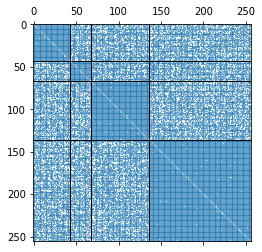

In [11]:
community_membership = utils.node_membership_to_community_membership(node_membership, num_classes, is_one_hot=True)
community_size = [len(community) for community in community_membership]
node_ids = np.concatenate(community_membership)
sorting_map = {}
for i in range(node_ids.shape[0]):
    sorting_map[node_ids[i]] = i

sorted_adj = np.zeros((num_nodes, num_nodes), dtype=np.int)

for (u, v), event_times in event_dict.items():
    if len(event_times) != 0:
        sorted_adj[sorting_map[u], sorting_map[v]] = 1

plt.spy(sorted_adj, marker='.', markersize=0.5, precision=0)
cumulative_community_size = 0
for com_size in community_size:
    cumulative_community_size += com_size
    plt.axhline(cumulative_community_size, color='black', linewidth=1)
    plt.axvline(cumulative_community_size, color='black', linewidth=1)

plt.show()

Here we can see the generated community structure in the generated network with the relative size of each community as well as more inter-community interactions vs. intra-community. Obviously this structure will change based on the model parameters.

# Fitting (retrieve / estimate model parameters) the generated CHIP network

## Spectral clustering on aggregated adjacency matrix

In [12]:
community_membership = utils.one_hot_to_class_assignment(node_membership)

agg_adj = utils.event_dict_to_aggregated_adjacency(num_nodes, event_dict, dtype=np.float)
est_node_membership = spectral_cluster(agg_adj, num_classes=num_classes)
rand = adjusted_rand_score(community_membership, est_node_membership)
print("Estimated Community assignment prob:", np.unique(est_node_membership, return_counts=True)[1] / num_nodes)
print("True Community assignment distribution:", np.unique(community_membership, return_counts=True)[1] / num_nodes)
print("Adjusted Rank Score:", rand)

Estimated Community assignment prob: [0.26953125 0.46875    0.16796875 0.09375   ]
True Community assignment distribution: [0.16796875 0.09375    0.26953125 0.46875   ]
Adjusted Rank Score: 1.0


## CHIP parameter estimation

In [13]:
(est_bp_mu, 
 est_bp_alpha, 
 est_bp_beta, 
 est_bp_m) = fitting_utils.estimate_bp_hawkes_params(event_dict, est_node_membership, end_time, num_classes, agg_adj)

### Estimated $\mu$

In [14]:
est_bp_mu

array([[4.84555526e-04, 9.68848418e-05, 1.04600055e-04, 9.94617307e-05],
       [1.02146208e-04, 5.12034009e-04, 1.00980435e-04, 9.81704962e-05],
       [1.03707119e-04, 9.84750721e-05, 5.10224706e-04, 1.01603951e-04],
       [1.09812986e-04, 1.02043416e-04, 1.05369049e-04, 5.16352856e-04]])

In [15]:
print('MSE:', np.mean((est_bp_mu - bp_mu) ** 2))

MSE: 5.895727358121144e-11


### Estimated $m$

In [16]:
est_bp_m

array([[0.78439078, 0.70357814, 0.67882814, 0.69509695],
       [0.68971656, 0.77245412, 0.67881462, 0.69238273],
       [0.68900443, 0.69334256, 0.76939718, 0.65337098],
       [0.66373834, 0.68221774, 0.66281904, 0.77754876]])

In [17]:
print('MSE:', np.mean((est_bp_m - (bp_alpha / bp_beta)) ** 2))

MSE: 0.0002477055820774565


### Estimated $\alpha$

In [18]:
est_bp_alpha

array([[0.14098241, 0.09085458, 0.09071191, 0.08985058],
       [0.08924655, 0.1392345 , 0.08551891, 0.0892335 ],
       [0.08911973, 0.09062246, 0.1392908 , 0.08695579],
       [0.08549786, 0.08708399, 0.08806748, 0.14005558]])

In [19]:
print('MSE:', np.mean((est_bp_alpha - bp_alpha) ** 2))

MSE: 4.21803524743567e-06


### Estimated $\beta$

In [20]:
est_bp_beta

array([[0.17973492, 0.12913218, 0.13363016, 0.12926337],
       [0.12939598, 0.18024954, 0.12598272, 0.12887887],
       [0.12934566, 0.13070373, 0.18103887, 0.13308793],
       [0.1288126 , 0.12764837, 0.13286805, 0.1801245 ]])

In [21]:
print('MSE:', np.mean((est_bp_beta - bp_beta) ** 2))

MSE: 3.6928726400341343e-06
